In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [3]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

In [6]:
dflog=pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


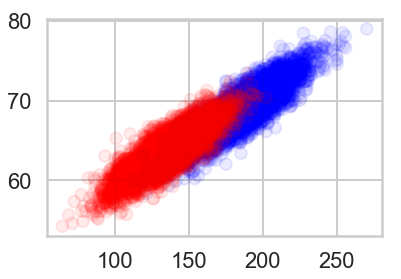

In [7]:
plt.scatter(dflog.Weight, dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=="Male"], alpha=0.08);

In [17]:
#from cs109 hw3, 2013
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    fold = KFold(nfold, shuffle=False, random_state=None)
    for train, test in fold.split(y): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [18]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, (dflog.Gender=="Male").values)

In [29]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0

for C in Cs:
        clf = LogisticRegression(solver='lbfgs', C=C)
        score = cv_score(clf, Xlr, ylr)

        if score > max_score:
            max_score = score
            best_C =C
print (max_score, best_C)

0.9182666666666666 0.1


In [28]:
clfl=LogisticRegression(solver = 'lbfgs', C=best_C)
clfl.fit(Xlr, ylr)
ypred=clfl.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

0.9132

In [27]:
from sklearn.model_selection import GridSearchCV
clfl2=LogisticRegression(solver='lbfgs')
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 {'C': 0.1},
 0.9177333333333333,
 {'mean_fit_time': array([0.04513836, 0.04042335, 0.02098765, 0.01852956, 0.01821589,
         0.01816077]),
  'std_fit_time': array([0.01196516, 0.00377643, 0.00227933, 0.00077719, 0.00056891,
         0.00034139]),
  'mean_score_time': array([0.0006    , 0.0006001 , 0.00040069, 0.00019994, 0.00080609,
         0.00039992]),
  'std_score_time': array([0.0004899 , 0.00048998, 0.00049074, 0.00039988, 0.00040312,
         0.0004898 ]),
  'param_C': masked_array(data=[0.0001, 0.001, 0.1, 1, 10, 100],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [

In [30]:
clfl2=LogisticRegression(solver = 'lbfgs', C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2=clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

0.9224

In [31]:
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [32]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

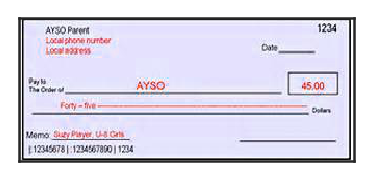

In [33]:
display_image(data[5])

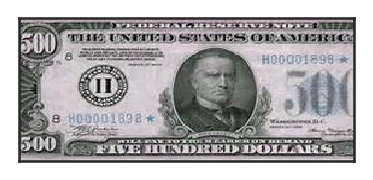

In [34]:
display_image(data[50])

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [36]:
print (pca.explained_variance_ratio_.sum())

0.9424003086607138


In [37]:
pca.explained_variance_ratio_*100

array([35.92596698,  6.29318801,  4.10778347,  3.11950952,  2.81695972,
        2.28831619,  2.10127948,  1.87404975,  1.73264633,  1.53023756,
        1.42159654,  1.31839386,  1.24701487,  1.1638178 ,  1.09958286,
        1.06073034,  1.00742714,  0.98023554,  0.96055574,  0.915355  ,
        0.90185107,  0.85212786,  0.83673899,  0.79690057,  0.7548857 ,
        0.72497456,  0.70814872,  0.67960942,  0.66083764,  0.64768311,
        0.62735199,  0.59473493,  0.58300191,  0.57430021,  0.57231905,
        0.55241037,  0.53826067,  0.53322082,  0.51630409,  0.49308227,
        0.48564835,  0.47728288,  0.47262671,  0.45591311,  0.44356478,
        0.4388622 ,  0.43324262,  0.42686773,  0.42111777,  0.40743363,
        0.40329089,  0.38968465,  0.38735041,  0.38198333,  0.3774618 ,
        0.35977792,  0.35573346,  0.34710817,  0.33199815,  0.32969168])

In [38]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,y,label,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,1,check,-22536.362571,-2428.343688,-2133.775360,-328.328400,-1065.249780,79.767699,-424.950975,622.445035,-2490.459915,-859.030890,-1072.809780,277.135298,-1117.156041,712.034922,-788.046558,417.041019,-198.297536,474.290513,-433.025281,-606.131043,-585.056997,-265.879988,-984.945003,958.545495,1040.749249,561.040791,-29.080712,-111.309063,-517.275818,537.521399,-636.667400,74.827491,-733.795228,-1330.718625,-429.421887,-150.373062,466.004118,304.066812,-232.223056,63.461032,-450.548774,805.968038,529.302015,-500.210348,477.530679,181.881255,-255.526823,266.540627,549.127856,-630.880946,-270.842485,96.965937,295.898268,197.302069,-269.843898,-353.417739,-519.052420,-198.710055,92.568968,329.093777
1,1,check,-22226.658684,-709.255354,-288.825265,-1300.632003,-792.096932,217.433925,1076.797548,-2115.113052,-875.634747,-1125.062212,-343.573586,-43.270189,547.704748,356.947578,-1761.945052,-370.161857,812.598985,295.082028,-943.303526,157.362483,-1118.853329,509.670379,-813.302050,725.442208,289.792057,-121.042906,833.021251,1145.403785,-349.097957,112.932786,-850.826710,582.003360,315.745210,-232.201616,-616.088948,-676.671665,-100.125513,-205.234243,-105.740434,-343.691347,124.116929,83.412048,700.034065,-22.133043,303.492999,-65.098859,-89.338287,395.110417,-1201.817369,80.461456,-503.532792,24.337715,253.175262,-299.916630,411.535603,-320.637085,-525.705781,-223.591829,-40.485577,340.474459
2,1,check,-17364.260784,-4252.026769,793.796469,-1362.044373,-374.190765,3142.152401,2514.126677,1443.828969,-120.678926,-419.093130,-2083.381520,1717.478473,-723.694890,-1239.030948,-310.422196,-1061.323633,1389.034328,-801.541173,-2596.595943,-884.899652,3382.840088,-386.151567,-3413.195900,1329.845445,-4759.699629,1068.838284,2187.085297,-672.524026,1378.480719,-2154.275498,-667.854662,1703.079048,1773.099836,3068.968149,-1161.530481,2330.005498,-3110.075347,2977.696743,823.516211,253.070851,1579.498260,-3068.349913,3715.046478,1551.919134,795.593132,-804.617792,-386.382270,-1263.943503,182.999517,-3414.040051,-1430.723023,-1805.201085,1105.717551,1790.169295,-1283.005600,-2485.750406,-1269.066631,-127.030525,1143.844152,-907.679810
3,1,check,-22847.256199,-900.593299,577.210026,-180.361929,-733.132258,-108.028909,1441.978841,-1069.805710,844.583321,-1390.210760,1471.277839,-723.104575,-577.129830,-259.900783,933.115950,173.427713,-304.728258,869.010881,-182.675964,1240.848664,558.780830,-171.123351,-339.893906,-368.934976,-918.629753,184.991775,1300.529107,66.012369,-320.206653,-479.386309,-151.297827,-86.840956,95.512721,-951.068163,-52.842340,579.064604,390.238993,397.833528,144.242782,-324.506978,1457.550255,-793.651029,-920.730711,522.896226,404.683479,604.041647,-991.089948,-370.360844,1023.502026,-1500.997769,789.029776,-444.000645,-272.294433,144.278921,212.440671,892.086400,103.033599,489.158858,699.796403,-387.452402
4,1,check,-15868.672595,3259.491244,506.794779,-919.619591,2166.585024,-981.526962,-1669.916567,-391.283401,1736.148234,164.505007,-1626.587249,-556.319070,-864.096312,1723.871982,945.106526,-1136.018319,2146.411570,765.178479,-1088.325506,596.026543,-36.165063,85.854140,-508.568095,1094.730632,324.234015,-1210.077384,-721.073097,-698.220831,-140.633012,-890.946135,994.545816,-3615.565663,2092.961816,3351.584087,-1358.177669,-2026.561303,1836.352646,2241.633329,2496.408180,-528.918756,47.407950,1409.243681,1138.991401,-1232.344898,-276.788390,989.685197,446.139534,1056.470610,-3042.314845,1148.331616,-1985.249384,-1831.153607,927.247932,-192.520299,3379.498656,1066.163929,2200.115352,2310.396611,1849.722241,1550.842497


In [39]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

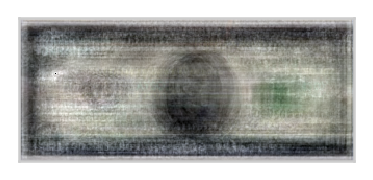

In [40]:
display_component(pca,0)

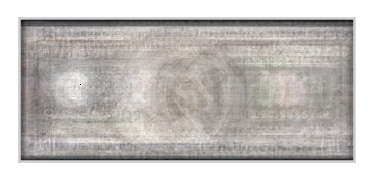

In [41]:
display_component(pca,1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


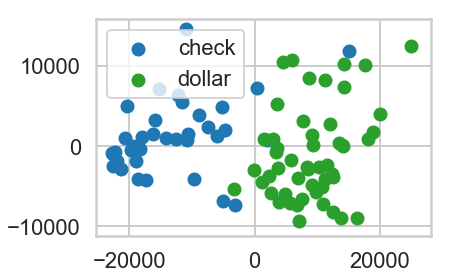

In [42]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print("Accuracy on training data: %0.2f" % (training_accuracy))
        print("Accuracy on test data:     %0.2f" % (test_accuracy))
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

Accuracy on training data: 1.00
Accuracy on test data:     0.94


(1, 1.0, 0.9428571428571428)

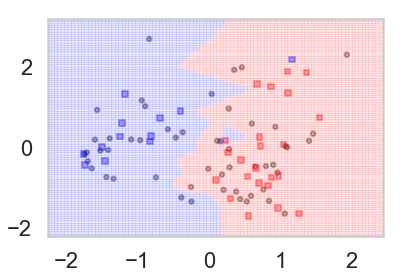

In [47]:
classify(Xs,ys,1)

Accuracy on training data: 0.56
Accuracy on test data:     0.63


(50, 0.5576923076923077, 0.6285714285714286)

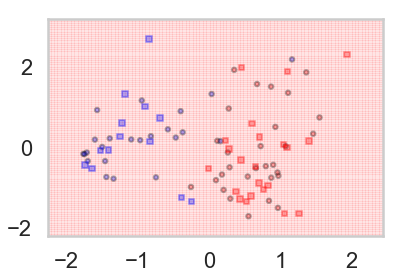

In [50]:
classify(Xs,ys,50)#run this a few times

In [51]:
fits={}
for k in np.arange(1,45,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

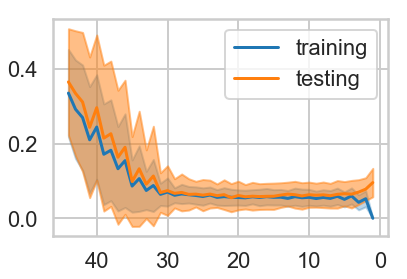

In [52]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

In [53]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [55]:
from sklearn.model_selection import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [56]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1,40,2)}, df, ['pc1','pc2'], 'label', 'check' )

BEST PARAMS {'n_neighbors': 5}
Accuracy on training data: 0.96
Accuracy on test data:     0.89


C:\Users\DELL\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


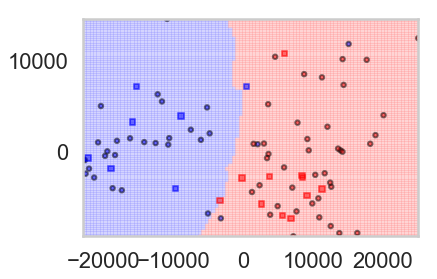

In [57]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


TypeError: clabel() got an unexpected keyword argument 'axes'

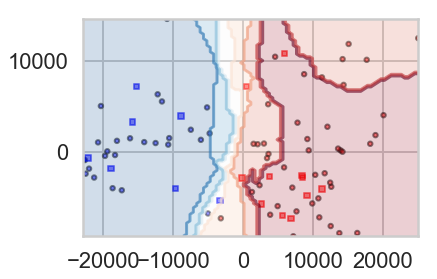

In [59]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest), )

array([[10,  1],
       [ 1,  6]], dtype=int64)

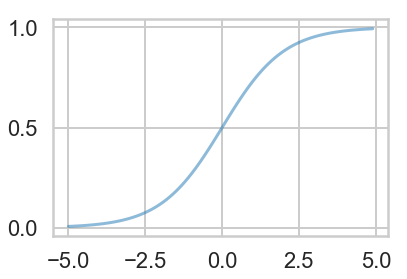

In [61]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [62]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [64]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(solver = "lbfgs"), {"C": [0.01, 0.1, 1, 10, 100]}, dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


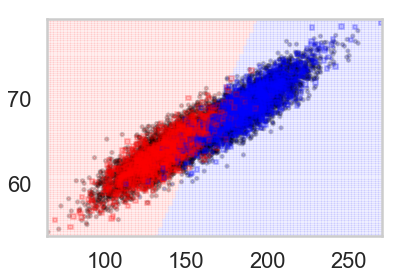

In [65]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In [66]:
clf_l.predict_proba(Xtest_l)

array([[1.69328614e-03, 9.98306714e-01],
       [9.55161172e-04, 9.99044839e-01],
       [9.99815572e-01, 1.84428286e-04],
       ...,
       [4.16834190e-04, 9.99583166e-01],
       [5.05926857e-01, 4.94073143e-01],
       [9.86778014e-01, 1.32219860e-02]])

C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


TypeError: clabel() got an unexpected keyword argument 'axes'

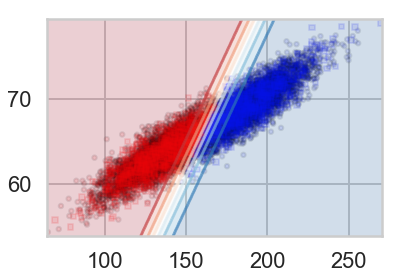

In [69]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);